## Projeto de Detecção de Fraude Transacional

In [1]:
# bibliotecas uteis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import itertools

#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_colwidth', 20)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score

In [26]:
# Carregando o arquivo parquet
path = "hackathon_transaction.parquet"
df_fraude = pd.read_parquet(path)
df_fraude.head()

,date,issuer_id,account_id,source_id,segment,depositwithdrawalflag,debitacctcountry,creditacctcountry,transaction_value,transaction_currencycode,...,product,fraud_flag,account_age,age,gender,marital_status,city,state,addresses_types,documents_types
0,2021-07-02,0bad865a02d82f4970687ffe1b80822b76cc0626,12c6fc06c99a462375eeb3f43dfd832b08ca9e17,4d134bc072212ace2df385dae143139da74ec0ef,Score,Q = Saque/Retirada de recurso,076,076,12000.0,986,...,TED,0,366,NaN,None,None,Florianopolis ...,SC,Residencial,cpf
1,2021-05-04,52fdb9f68c503e11d168fe52035901864c0a4861,e54183e2a040e6c09e61eb22d542e3d57074b351,bcf814ab41506290ab1b8158ebda6ee61b4bb579,Score,D = Depósito/Entrada de recurso,076,076,10.0,NULL,...,PIX,0,491,NaN,None,None,São Paulo ...,SP,Residencial,rg
2,2021-05-04,52fdb9f68c503e11d168fe52035901864c0a4861,e54183e2a040e6c09e61eb22d542e3d57074b351,bcf814ab41506290ab1b8158ebda6ee61b4bb579,Score,D = Depósito/Entrada de recurso,076,076,1.0,NULL,...,PIX,0,491,NaN,None,None,São Paulo ...,SP,Residencial,rg
3,2021-05-04,52fdb9f68c503e11d168fe52035901864c0a4861,e54183e2a040e6c09e61eb22d542e3d57074b351,bcf814ab41506290ab1b8158ebda6ee61b4bb579,Score,D = Depósito/Entrada de recurso,076,076,10.0,NULL,...,PIX,0,491,NaN,None,None,São Paulo ...,SP,Residencial,rg
4,2021-05-04,52fdb9f68c503e11d168fe52035901864c0a4861,e54183e2a040e6c09e61eb22d542e3d57074b351,bcf814ab41506290ab1b8158ebda6ee61b4bb579,Score,D = Depósito/Entrada de recurso,076,076,1.0,NULL,...,PIX,0,491,NaN,None,None,São Paulo ...,SP,Residencial,rg


### Análise exploratória

In [27]:
# verificando os tipos de variáveis
df_fraude.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334384 entries, 0 to 334383
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   date                      334384 non-null  object 
 1   issuer_id                 334384 non-null  object 
 2   account_id                334384 non-null  object 
 3   source_id                 334384 non-null  object 
 4   segment                   334384 non-null  object 
 5   depositwithdrawalflag     334384 non-null  object 
 6   debitacctcountry          334384 non-null  object 
 7   creditacctcountry         334384 non-null  object 
 8   transaction_value         334384 non-null  float64
 9   transaction_currencycode  123711 non-null  object 
 10  transactiontype           334384 non-null  object 
 11  accesschannel             334384 non-null  object 
 12  processingchannel         334384 non-null  object 
 13  onusflag                  334384 non-null  o

In [28]:
# Select duplicate rows except first occurrence based on all columns

duplicateRowsDF = df_fraude[df_fraude.duplicated()]

print("Número de linhas duplicadas:")

print(len(duplicateRowsDF.axes[1]))

#Removendo as duplicadas

df_fraude = df_fraude.drop_duplicates()

Número de linhas duplicadas:
27


In [35]:
df_fraude.head()

,date,issuer_id,account_id,source_id,segment,depositwithdrawalflag,debitacctcountry,creditacctcountry,transaction_value,transaction_currencycode,...,reversalindicator,score_adpt_falcon,rule_name,product,fraud_flag,account_age,city,state,addresses_types,documents_types
0,2021-07-02,0bad865a02d82f4970687ffe1b80822b76cc0626,12c6fc06c99a462375eeb3f43dfd832b08ca9e17,4d134bc072212ace2df385dae143139da74ec0ef,Score,Q = Saque/Retirada de recurso,076,076,12000.00,986,...,Não é uma reversão,NULL,Nega_TedOut_10K,TED,0,366,Florianopolis ...,SC,Residencial,cpf
1,2021-05-04,52fdb9f68c503e11d168fe52035901864c0a4861,e54183e2a040e6c09e61eb22d542e3d57074b351,bcf814ab41506290ab1b8158ebda6ee61b4bb579,Score,D = Depósito/Entrada de recurso,076,076,10.00,NULL,...,Não é uma reversão,NULL,Lista_PixIn_Qtd,PIX,0,491,São Paulo ...,SP,Residencial,rg
2,2021-05-04,52fdb9f68c503e11d168fe52035901864c0a4861,e54183e2a040e6c09e61eb22d542e3d57074b351,bcf814ab41506290ab1b8158ebda6ee61b4bb579,Score,D = Depósito/Entrada de recurso,076,076,1.00,NULL,...,Não é uma reversão,NULL,Lista_PixIn_Qtd,PIX,0,491,São Paulo ...,SP,Residencial,rg
8,2021-03-01,5d23e965603269f7674c2fc33318f5d5af406f6f,ca3799b8ff860c55da009a5675031b8644cdf7e3,6643521711328a1e282daf5a5da43970eb11a089,modelSTUB,Q = Saque/Retirada de recurso,076,076,0.99,NULL,...,Não é uma reversão,NULL,Lista_Fora_Horario_Corte,PIX,0,483,Fortaleza ...,CE,Residencial,cnpj
9,2021-12-01,5d23e965603269f7674c2fc33318f5d5af406f6f,ca3799b8ff860c55da009a5675031b8644cdf7e3,6643521711328a1e282daf5a5da43970eb11a089,Score,Q = Saque/Retirada de recurso,076,076,24.81,None,...,Nao é uma reversao,2,Lista_Fora_Horario_Corte,PIX,0,483,Fortaleza ...,CE,Residencial,cnpj


In [31]:
NullRowsDF = df_fraude[df_fraude.isnull()]

print("Número de linhas Nulas:")

print(len(NullRowsDF.axes[1]))

df_fraude = df_fraude.dropna(how='all', axis=1)

Número de linhas Nulas:
27


In [34]:
NullRowsDF

,date,issuer_id,account_id,source_id,segment,depositwithdrawalflag,debitacctcountry,creditacctcountry,transaction_value,transaction_currencycode,...,product,fraud_flag,account_age,age,gender,marital_status,city,state,addresses_types,documents_types
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
334380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
334381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
334382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df_fraude_cats = df_fraude.select_dtypes(include='object').describe()

In [37]:
# selecionando apenas as variáveis categóricas
df_fraude.select_dtypes(include='object').describe()

,date,issuer_id,account_id,source_id,segment,depositwithdrawalflag,debitacctcountry,creditacctcountry,transaction_currencycode,transactiontype,...,processingchannel,onusflag,reversalindicator,score_adpt_falcon,rule_name,product,city,state,addresses_types,documents_types
count,332316,332316,332316,332316,332316,332316,332316,332316,121723,332316,...,332316,332316,332316,319843,332316,332316,331591,331591,331591,332316
unique,363,57,54225,57522,2,3,2,2,2,3,...,4,3,4,622,246,5,5378,39,4,5
top,2021-12-13,5d23e965603269f7674c2fc33318f5d5af406f6f,f4cc5bc52436baa9505b2d60911299bbd560a79a,1b6453892473a467d07372d45eb05abc2031647a,Score,Q = Saque/Retirada de recurso,076,076,NULL,U = Transferência/pagamento imediato único e u...,...,P = Pagamentos mais rápidos (UK only),E,Nao é uma reversao,2,Lista_Fora_Horario_Corte,PIX,São Paulo ...,SP,Residencial,rg
freq,8433,275080,395,1011,305486,321312,329744,329744,110020,325306,...,320613,316489,213115,127733,273953,320613,30920,107022,330951,163883


In [38]:
list(df_fraude_cats.columns)

['date',
 'issuer_id',
 'account_id',
 'source_id',
 'segment',
 'depositwithdrawalflag',
 'debitacctcountry',
 'creditacctcountry',
 'transaction_currencycode',
 'transactiontype',
 'accesschannel',
 'processingchannel',
 'onusflag',
 'reversalindicator',
 'score_adpt_falcon',
 'rule_name',
 'product',
 'city',
 'state',
 'addresses_types',
 'documents_types']

In [39]:
# Ordinal encoding
from category_encoders.one_hot import OrdinalEncoder

In [42]:
#ord
ord_end = OrdinalEncoder(cols = ['date',
 'issuer_id',
 'account_id',
 'source_id',
 'segment',
 'depositwithdrawalflag',
 'debitacctcountry',
 'creditacctcountry',
 'transaction_currencycode',
 'transactiontype',
 'accesschannel',
 'processingchannel',
 'onusflag',
 'reversalindicator',
 'score_adpt_falcon',
 'rule_name',
 'product',
 'city',
 'state',
 'addresses_types',
 'documents_types'])
df_fraude_cats_oe = ord_end.fit_transform(df_fraude)

In [43]:
df_fraude_cats_oe

,date,issuer_id,account_id,source_id,segment,depositwithdrawalflag,debitacctcountry,creditacctcountry,transaction_value,transaction_currencycode,...,reversalindicator,score_adpt_falcon,rule_name,product,fraud_flag,account_age,city,state,addresses_types,documents_types
0,1,1,1,1,1,1,1,1,12000.00,1,...,1,1,1,1,0,366,1,1,1,1
1,2,2,2,2,1,2,1,1,10.00,2,...,1,1,2,2,0,491,2,2,1,2
2,2,2,2,2,1,2,1,1,1.00,2,...,1,1,2,2,0,491,2,2,1,2
8,3,3,3,3,2,1,1,1,0.99,2,...,1,1,3,2,0,483,3,3,1,3
9,4,3,3,3,1,1,1,1,24.81,3,...,2,2,3,2,0,483,3,3,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334379,146,27,54224,57520,1,1,1,1,728.95,1,...,1,1,41,3,0,301,5378,6,1,1
334380,146,27,54224,57521,1,1,1,1,728.95,1,...,1,1,41,3,0,259,5379,13,1,1
334381,193,27,54224,57520,1,1,1,1,171.21,2,...,1,1,45,2,0,301,5378,6,1,1
334382,193,27,54224,57521,1,1,1,1,171.21,2,...,1,1,45,2,0,259,5379,13,1,1


In [44]:
#descrição de uma coluna
df_fraude_cats_oe["transaction_value"].describe()

count    3.323160e+05
mean     7.340991e+03
std      2.453840e+06
min      1.000000e-02
25%      1.585000e+01
50%      4.680000e+01
75%      1.612125e+02
max      1.000000e+09
Name: transaction_value, dtype: float64

In [46]:
non_fraud = len(df_fraude_cats_oe[df_fraude_cats_oe.fraud_flag == 0])
fraud = len(df_fraude_cats_oe[df_fraude_cats_oe.fraud_flag == 1])
fraud_percent = (fraud / (fraud + non_fraud)) * 100

print("Numero de Transações não fraudulentas: ", non_fraud)
print("Numero de Transações fraudulentas: ", fraud)
print("Percentual de Transações fraudulentas: {:.4f}".format(fraud_percent))

Numero de Transações não fraudulentas:  330620
Numero de Transações fraudulentas:  1696
Percentual de Transações fraudulentas: 0.5104


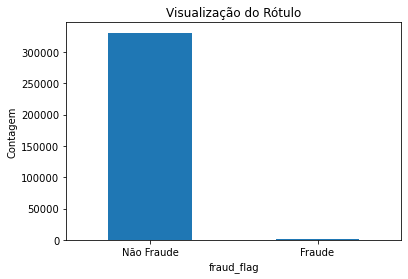

In [47]:
# Visualizando as fraudes contra as não fraudes 

labels = ["Não Fraude", "Fraude"]
count_fraud_flags = df_fraude_cats_oe.value_counts(df_fraude_cats_oe['fraud_flag'], sort= True)
count_fraud_flags.plot(kind = "bar", rot = 0)
plt.title("Visualização do Rótulo")
plt.ylabel("Contagem")
plt.xticks(range(2), labels)
plt.show()

In [48]:
df_fraude_cats_oe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332316 entries, 0 to 334383
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   date                      332316 non-null  int32  
 1   issuer_id                 332316 non-null  int32  
 2   account_id                332316 non-null  int32  
 3   source_id                 332316 non-null  int32  
 4   segment                   332316 non-null  int32  
 5   depositwithdrawalflag     332316 non-null  int32  
 6   debitacctcountry          332316 non-null  int32  
 7   creditacctcountry         332316 non-null  int32  
 8   transaction_value         332316 non-null  float64
 9   transaction_currencycode  332316 non-null  int32  
 10  transactiontype           332316 non-null  int32  
 11  accesschannel             332316 non-null  int32  
 12  processingchannel         332316 non-null  int32  
 13  onusflag                  332316 non-null  i

In [49]:
# Normalizando os dados
scaler = StandardScaler()
df_fraude_cats_oe["NormalizedAmount"] = scaler.fit_transform(df_fraude_cats_oe["transaction_value"].values.reshape(-1, 1))
# tirando valores não utilizados
#df_fraude.drop(["transaction_value", "age", "gender", "marital_status", "date", "issuer_id", "account_id", "source_id"], inplace= True, axis= 1)

Y = df_fraude_cats_oe["fraud_flag"]
X = df_fraude_cats_oe.drop(["fraud_flag"], axis= 1)

In [50]:
df_fraude_cats_oe.to_csv('DataFrame_Ajustado.csv')

In [52]:
# apagando features pouco relevantes
X.drop(["transaction_value", "date", "issuer_id", "account_id", "source_id"], inplace= True, axis= 1)

In [53]:
Y.head()

0    0
1    0
2    0
8    0
9    0
Name: fraud_flag, dtype: int32

In [54]:
# Split the data
(train_X, test_X, train_Y, test_Y) = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of train_X: ", train_X.shape)
print("Shape of test_X: ", test_X.shape)

Shape of train_X:  (232621, 19)
Shape of test_X:  (99695, 19)


In [55]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232621 entries, 274677 to 122785
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   segment                   232621 non-null  int32  
 1   depositwithdrawalflag     232621 non-null  int32  
 2   debitacctcountry          232621 non-null  int32  
 3   creditacctcountry         232621 non-null  int32  
 4   transaction_currencycode  232621 non-null  int32  
 5   transactiontype           232621 non-null  int32  
 6   accesschannel             232621 non-null  int32  
 7   processingchannel         232621 non-null  int32  
 8   onusflag                  232621 non-null  int32  
 9   reversalindicator         232621 non-null  int32  
 10  score_adpt_falcon         232621 non-null  int32  
 11  rule_name                 232621 non-null  int32  
 12  product                   232621 non-null  int32  
 13  account_age               232621 non-nu

#### Vamos treinar uma Árvore de Decisão e uma Random Forest e observar qual funciona melhor no problema

## Arvore de Decisao

In [56]:
# Decision Tree Classifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_X, train_Y)

predictions_dt = decision_tree.predict(test_X)
decision_tree_score = decision_tree.score(test_X, test_Y) * 100

### Random Forest

In [57]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(train_X, train_Y)

predictions_rf = random_forest.predict(test_X)
random_forest_score = random_forest.score(test_X, test_Y) * 100

### Comparando os modelos

In [58]:
# Print scores of our classifiers

print("Random Forest Score: ", random_forest_score)
print("Decision Tree Score: ", decision_tree_score)

Random Forest Score:  99.5004764531822
Decision Tree Score:  99.17548522995135


In [59]:
# função do scikit para calcular a confusion matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [60]:
# Plot confusion matrix for Decision Trees

confusion_matrix_dt = confusion_matrix(test_Y, predictions_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt)

Confusion Matrix - Decision Tree
[[98776   429]
 [  393    97]]


Confusion matrix, without normalization


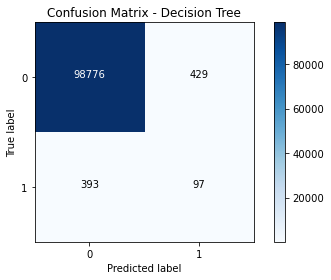

In [61]:
plot_confusion_matrix(confusion_matrix_dt, classes=[0, 1], title= "Confusion Matrix - Decision Tree")

In [62]:
# Plot confusion matrix for Random Forests

confusion_matrix_rf = confusion_matrix(test_Y, predictions_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)

Confusion Matrix - Random Forest
[[99150    55]
 [  443    47]]


Confusion matrix, without normalization


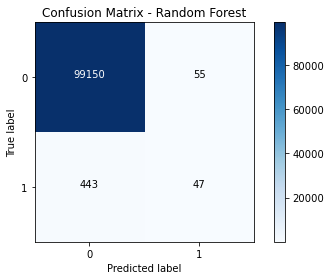

In [63]:
plot_confusion_matrix(confusion_matrix_rf, classes=[0, 1], title= "Confusion Matrix - Random Forest")

In [64]:
# função que define Metricas

def metrics(actuals, predictions):
    print("Acuracia: {:.5f}".format(accuracy_score(actuals, predictions)))
    print("Precisão: {:.5f}".format(precision_score(actuals, predictions)))
    print("Recall: {:.5f}".format(recall_score(actuals, predictions)))
    print("F1-score: {:.5f}".format(f1_score(actuals, predictions)))
    

In [65]:
print("Análise do Modelo de Árvore de Decisão")
print()
metrics(test_Y, predictions_dt.round())

Análise do Modelo de Árvore de Decisão

Acuracia: 0.99175
Precisão: 0.18441
Recall: 0.19796
F1-score: 0.19094


In [66]:
print("Análise do Modelo de Random Forest")
print()
metrics(test_Y, predictions_rf.round())

Análise do Modelo de Random Forest

Acuracia: 0.99500
Precisão: 0.46078
Recall: 0.09592
F1-score: 0.15878


### Quem funcionou melhor?

**Synthetic Minority Oversampling Technique** ou **SMOTE**

In [67]:
# Oversampling da Random Forest e Árvore de Decisão

from imblearn.over_sampling import SMOTE 

X_resampled, Y_resampled = SMOTE().fit_resample(train_X, train_Y)
print("Resampled shape of X: ", X_resampled.shape)
print("Resampled shape of Y: ", Y_resampled.shape)

value_counts = Counter(Y_resampled)
print(value_counts)

#(train_X, test_X, train_Y, test_Y) = train_test_split(X_resampled, Y_resampled, test_size= 0.3, random_state= 42) correção samuel

Resampled shape of X:  (462830, 19)
Resampled shape of Y:  (462830,)
Counter({0: 231415, 1: 231415})


In [68]:
# Classificador Random Forest no novo conjunto de dados

rf_resampled = RandomForestClassifier(n_estimators = 100)
rf_resampled.fit(X_resampled, Y_resampled)

predictions_resampled = rf_resampled.predict(test_X)
random_forest_score_resampled = rf_resampled.score(test_X, test_Y) * 100

In [69]:
# Confusion matrix

cm_resampled = confusion_matrix(test_Y, y_predict.round())
print("Confusion Matrix - Random Forest")
print(cm_resampled)

NameError: name 'y_predict' is not defined

In [70]:
plot_confusion_matrix(cm_resampled, classes=[0, 1], title= "Confusion Matrix - Random Forest After Oversampling")

NameError: name 'cm_resampled' is not defined

In [71]:
print("Análise do Modelo de Random Forest depois do Oversampling")
print()
metrics(test_Y, predictions_resampled.round())

Análise do Modelo de Random Forest depois do Oversampling

Acuracia: 0.98948
Precisão: 0.18203
Recall: 0.32653
F1-score: 0.23375


In [39]:
### Anterior
print("Evaluation of Random Forest Model")
print()
metrics(test_Y, predictions_resampled.round())

Evaluation of Random Forest Model

Acuracia: 0.99409
Precisão: 0.99055
Recall: 0.99772
F1-score: 0.99412


Usando o problema desbalanceado, o Random Forest funciona melhor com Smote.
